# Census income classification with XGBoost

This notebook demonstrates how to use XGBoost to predict the probability of an individual making over $50K a year in annual income. It uses the standard UCI Adult income dataset. Based on one of Scott Lundberg's SHAP master notebooks: [github](https://github.com/slundberg/shap/tree/master/notebooks).

Using SHAP values to understand XGBoost model predictions. 


In [0]:
!pip install shap

In [0]:
from sklearn.model_selection import train_test_split
import xgboost
import shap
import numpy as np
import matplotlib.pylab as pl

## Load dataset

In [0]:
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

Descriptions of the dataset attributes

| Attribute Name | Type | Description |
|-----------------------|----------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Age | Continuous | Represents age of the person |
| Workclass | Categorical | Represents the nature of working class\category<br>(Private, Self-emp-not-inc, Self-emp-inc, Federal-gov,  <br>Local-gov, State-gov, Without-pay, Never-worked) |
| Education-Num | Categorical | Numeric representation of educational qualification.<br>Ranges from 1-16.<br>(Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, <br>9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool) |
| Marital Status | Categorical | Represents the marital status of the person<br>(Married-civ-spouse, Divorced, Never-married, Separated, <br>Widowed, Married-spouse-absent, Married-AF-spouse) |
| Occupation | Categorical | Represents the type of profession\job of the person<br>(Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, <br>Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, <br>Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, <br>Armed-Forces) |
| Relationship | Categorical | Represents the relationship status of the person<br>(Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried) |
| Race | Categorical | Represents the race of the person<br>(White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black) |
| Sex | Categorical | Represents the gender of the person<br>(Female, Male) |
| Capital Gain | Continuous | The total capital gain for the person |
| Capital Loss | Continuous | The total capital loss for the person |
| Hours per week | Continuous | Total hours spent working per week |
| Country | Categorical | The country where the person is residing |
| Income Label (labels) | Categorical  (class label) | The class label column is the one we want to predict<br>(False: Income <= \$50K & True: Income > \$50K) |                                                                                                                                                                |

Objective - predict if the income of a person will be more than \$50K (True) or less than \$50K (False)

## Train the model

In [4]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss"
}
model = xgboost.train(params, d_train, 5000, evals = [(d_test, "test")], verbose_eval=100, early_stopping_rounds=20)

[0]	test-logloss:0.54662
Will train until test-logloss hasn't improved in 20 rounds.
[100]	test-logloss:0.363727
[200]	test-logloss:0.317929
[300]	test-logloss:0.300611
[400]	test-logloss:0.292068
[500]	test-logloss:0.286775
[600]	test-logloss:0.283809
[700]	test-logloss:0.281807
[800]	test-logloss:0.280643
[900]	test-logloss:0.27992
[1000]	test-logloss:0.279281
Stopping. Best iteration:
[999]	test-logloss:0.279272



## Classic feature attributions

Global feature importance calcuations with XGBoost. Notice that they are all different.

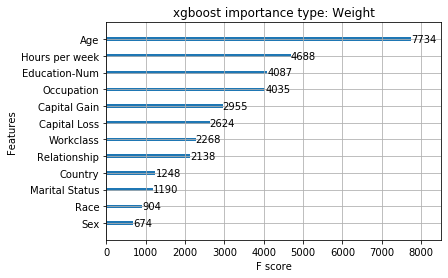

In [6]:
xgboost.plot_importance(model, importance_type="weight")
pl.title('xgboost importance type: Weight')
pl.show()

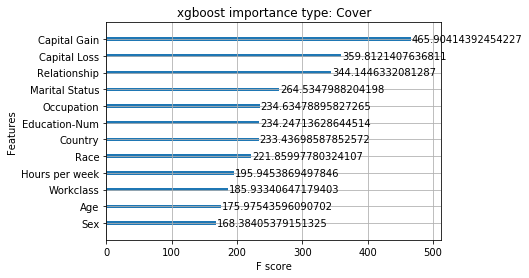

In [7]:
xgboost.plot_importance(model, importance_type="cover")
pl.title('xgboost importance type: Cover')
pl.show()

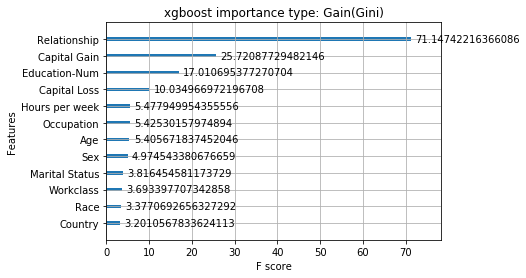

In [8]:
xgboost.plot_importance(model, importance_type="gain")
pl.title('xgboost importance type: Gain(Gini)')
pl.show()

## Explain predictions

Use the Tree SHAP implementation integrated into XGBoost to explain the entire dataset (32561 samples)

In [0]:
# this takes a few minutes since we are explaining over 30 thousand samples in a model with over a thousand trees
explainer = shap.TreeExplainer(model)
all_shap_values = explainer.shap_values(X)

### Visualize a single prediction

Use the "display values" data frame to get nice strings instead of category codes 

In [10]:
# print the JS visualization code to the notebook
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[0,:], X_display.iloc[0,:])

In [18]:
shap.initjs()

# Need to constrain the array index size so subsample and allow for feature dependence outside the tree path
explainer = shap.TreeExplainer(model, X.iloc[:300,:], feature_dependence="independent")

shap_values = explainer.shap_values(X.iloc[71,:])

shap.force_plot(explainer.expected_value, shap_values, X_display.iloc[71,:])

In [20]:
shap.initjs()

shap_values = explainer.shap_values(X.iloc[241,:])

shap.force_plot(explainer.expected_value, shap_values, X_display.iloc[241,:])

In [21]:
shap.initjs()

shap_values = explainer.shap_values(X.iloc[299,:])

shap.force_plot(explainer.expected_value, shap_values, X_display.iloc[299,:])

In [22]:
shap.initjs()

shap_values = explainer.shap_values(X.iloc[59,:])

shap.force_plot(explainer.expected_value, shap_values, X_display.iloc[59,:])

In [23]:
shap.initjs()

shap_values = explainer.shap_values(X.iloc[26,:])

shap.force_plot(explainer.expected_value, shap_values, X_display.iloc[26,:])

### Visualize many predictions

For the browser's sake only visualize 200 individuals.

In [31]:
shap.initjs()

shap.force_plot(explainer.expected_value, all_shap_values[:200,:], X_display.iloc[:200,:])

## Bar chart of mean importance

This takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.

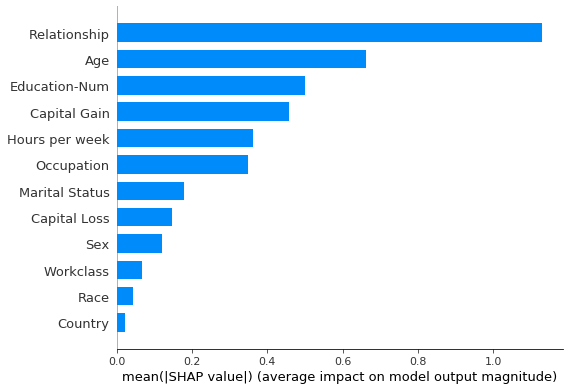

In [32]:
shap.summary_plot(all_shap_values, X_display, plot_type="bar")

## SHAP Summary Plot

Rather than use a typical feature importance bar chart, we use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. It is interesting to note that the relationship feature has more total model impact than the captial gain feature, but for those samples where capital gain matters it has more impact than age. In other words, capital gain effects a few predictions by a large amount, while age effects all predictions by a smaller amount.

Note that when the scatter points don't fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.

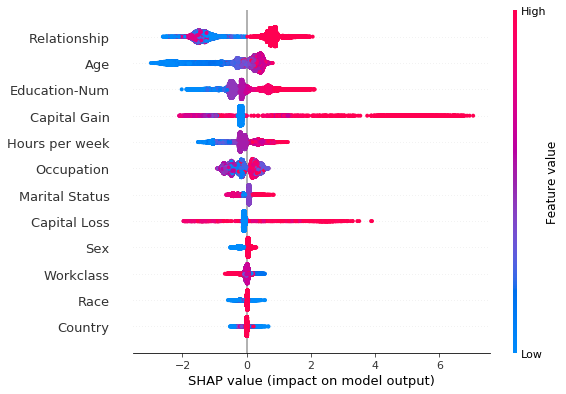

In [33]:
shap.summary_plot(all_shap_values, X)

## SHAP Dependence Plots

SHAP dependence plots show the effect of a single feature across the whole dataset. They plot a feature's value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the **interaction** effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions.

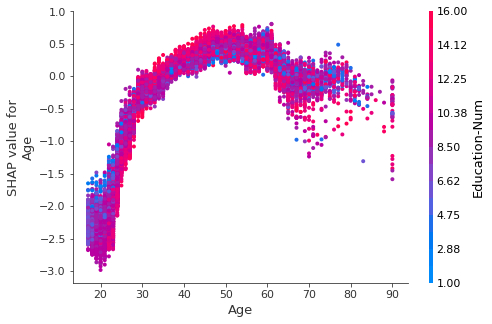

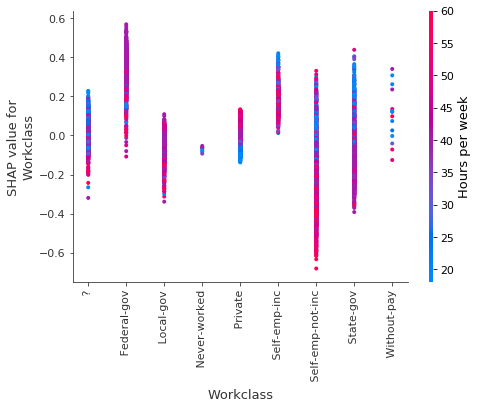

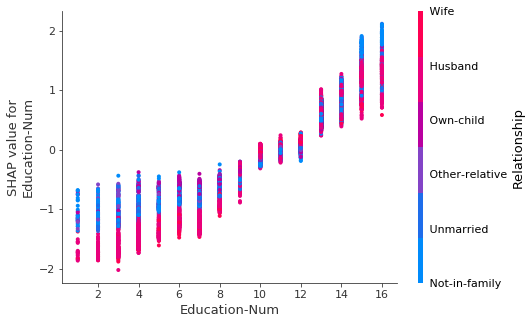

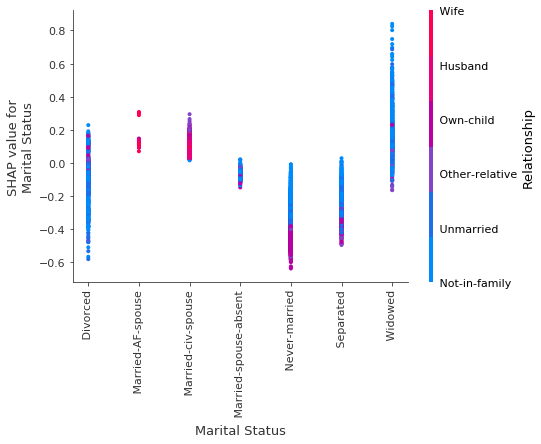

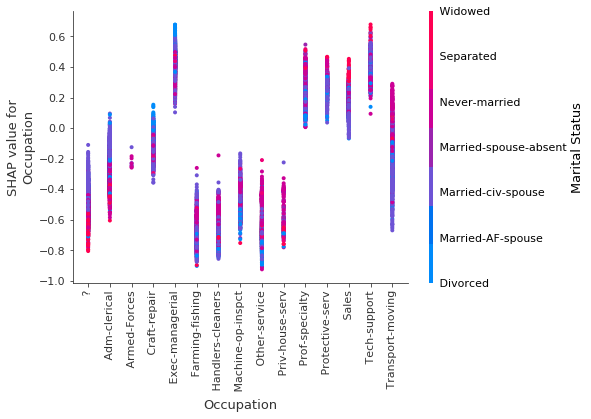

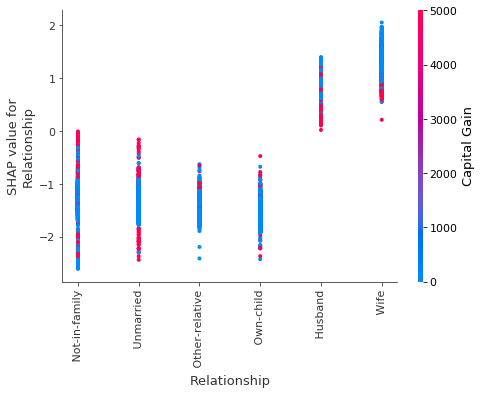

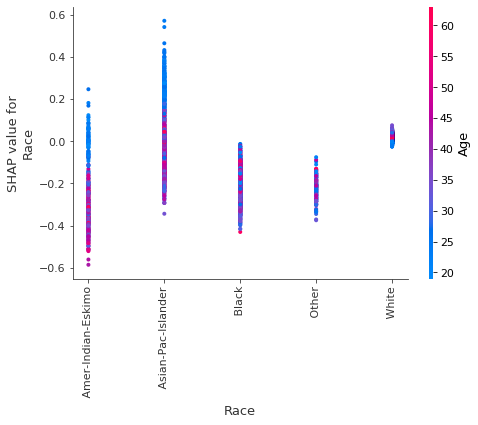

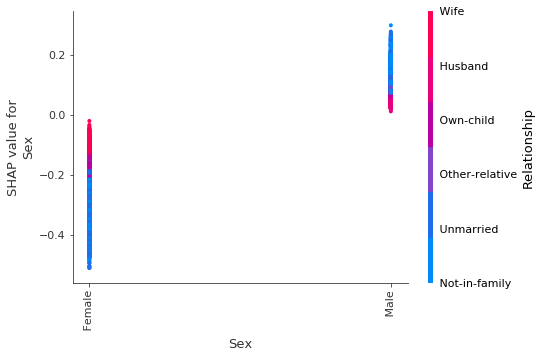

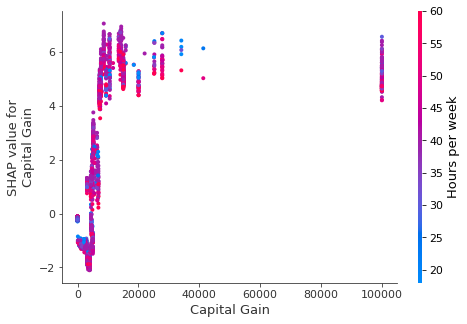

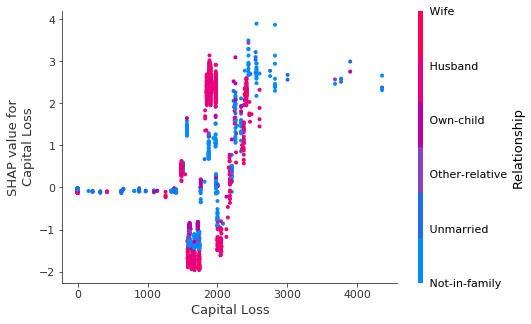

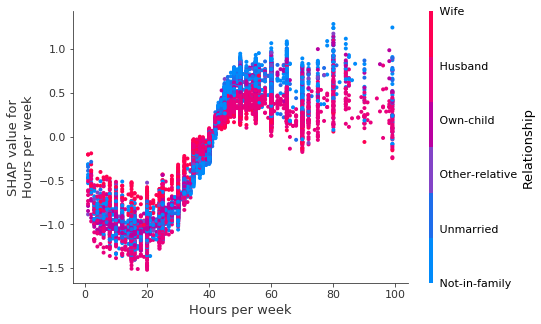

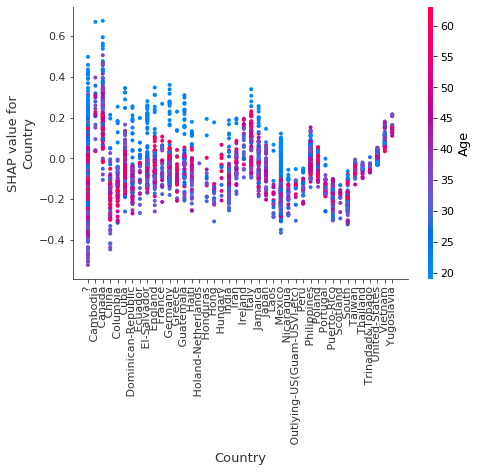

In [34]:
for name in X_train.columns:
    shap.dependence_plot(name, all_shap_values, X, display_features=X_display)

## Simple supervised clustering

Clustering people by their shap_values leads to groups relevent to the prediction task at hand (their earning potential in this case).

In [0]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

shap_pca50 = PCA(n_components=12).fit_transform(all_shap_values[:1000,:])
shap_embedded = TSNE(n_components=2, perplexity=50).fit_transform(all_shap_values[:1000,:])

In [0]:
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
cdict1 = {
    'red': ((0.0, 0.11764705882352941, 0.11764705882352941),
            (1.0, 0.9607843137254902, 0.9607843137254902)),

    'green': ((0.0, 0.5333333333333333, 0.5333333333333333),
              (1.0, 0.15294117647058825, 0.15294117647058825)),

    'blue': ((0.0, 0.8980392156862745, 0.8980392156862745),
             (1.0, 0.3411764705882353, 0.3411764705882353)),

    'alpha': ((0.0, 1, 1),
              (0.5, 1, 1),
              (1.0, 1, 1))
}  # #1E88E5 -> #ff0052
red_blue_solid = LinearSegmentedColormap('RedBlue', cdict1)

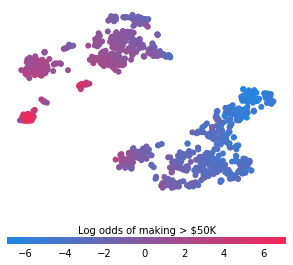

In [38]:
f = pl.figure(figsize=(5,5))
pl.scatter(shap_embedded[:,0],
           shap_embedded[:,1],
           c=all_shap_values[:1000,:].sum(1).astype(np.float64),
           linewidth=0, alpha=1., cmap=red_blue_solid)
cb = pl.colorbar(label="Log odds of making > $50K", aspect=40, orientation="horizontal")
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
pl.gca().axis("off")
pl.show()

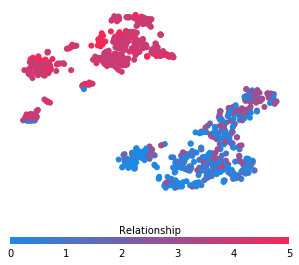

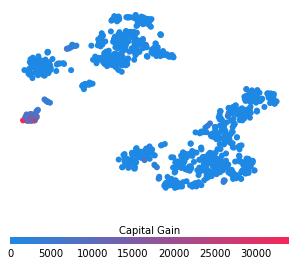

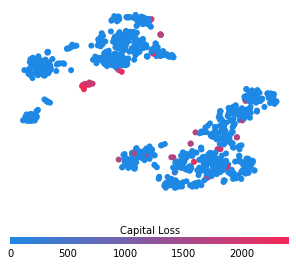

In [39]:
for feature in ["Relationship", "Capital Gain", "Capital Loss"]:
    f = pl.figure(figsize=(5,5))
    pl.scatter(shap_embedded[:,0],
               shap_embedded[:,1],
               c=X[feature].values[:1000].astype(np.float64),
               linewidth=0, alpha=1., cmap=red_blue_solid)
    cb = pl.colorbar(label=feature, aspect=40, orientation="horizontal")
    cb.set_alpha(1)
    cb.draw_all()
    cb.outline.set_linewidth(0)
    cb.ax.tick_params('x', length=0)
    cb.ax.xaxis.set_label_position('top')
    pl.gca().axis("off")
    pl.show()

### Train a model with only two leaves per tree and hence no interaction terms between features

Forcing the model to have no interaction terms means the effect of a feature on the outcome does not depend on the value of any other feature. This is reflected in the SHAP dependence plots below without vertical spread. A vertical spread reflects that a single value of a feature can have different effects on the model output depending on the context of the other features present for an individual. However, for models without interaction terms, a feature always has the same impact regardless of what other attributes an individual may have.

One the benefits of SHAP dependence plots over traditional partial dependence plots is this ability to distigush between between models with and without interaction terms. In other words, SHAP dependence plots give an idea of the magnitude of the interaction terms through the vertical variance of the scatter plot at a given feature value.

In [40]:
# train final model on the full data set
params = {
    "eta": 0.05,
    "max_depth": 1,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss"
}
model_ind = xgboost.train(params, d_train, 5000, evals = [(d_test, "test")], verbose_eval=100, early_stopping_rounds=20)

[0]	test-logloss:0.541124
Will train until test-logloss hasn't improved in 20 rounds.
[100]	test-logloss:0.354994
[200]	test-logloss:0.328477
[300]	test-logloss:0.319012
[400]	test-logloss:0.313311
[500]	test-logloss:0.309297
[600]	test-logloss:0.306193
[700]	test-logloss:0.303711
[800]	test-logloss:0.301841
[900]	test-logloss:0.300346
[1000]	test-logloss:0.299129
[1100]	test-logloss:0.297959
[1200]	test-logloss:0.296945
[1300]	test-logloss:0.296062
[1400]	test-logloss:0.295253
[1500]	test-logloss:0.294713
Stopping. Best iteration:
[1546]	test-logloss:0.294321



In [0]:
shap_values_ind = shap.TreeExplainer(model_ind).shap_values(X)

Note that the interaction color bars below are meaningless for this model because it has no interactions.

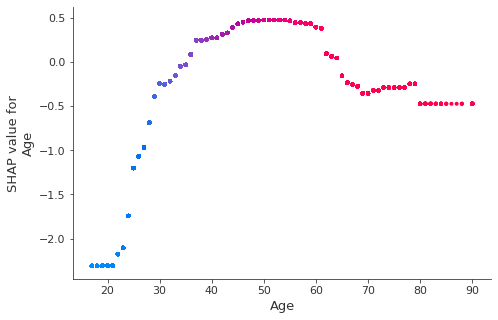

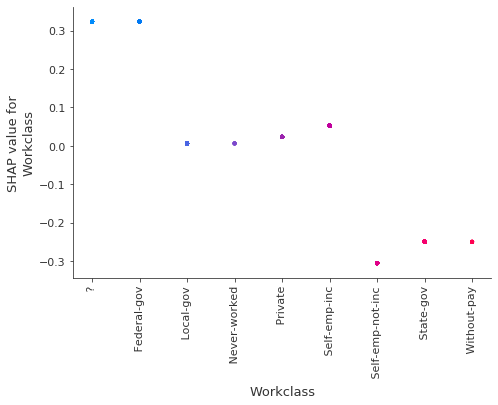

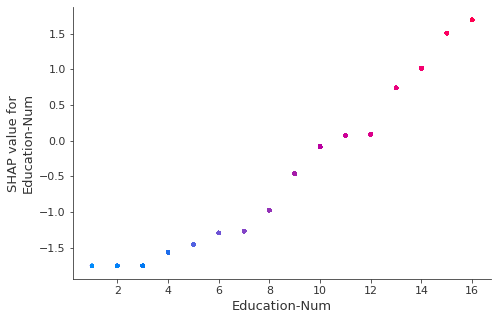

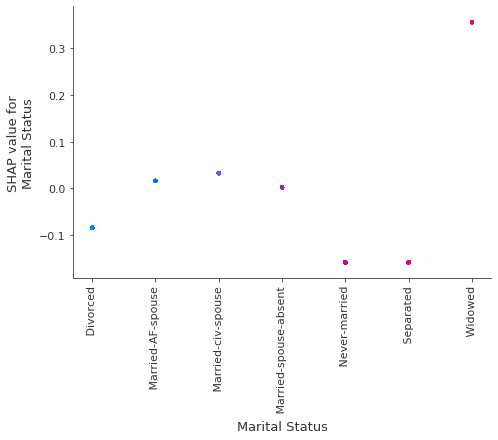

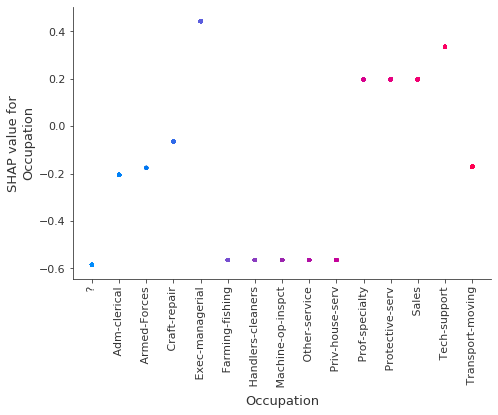

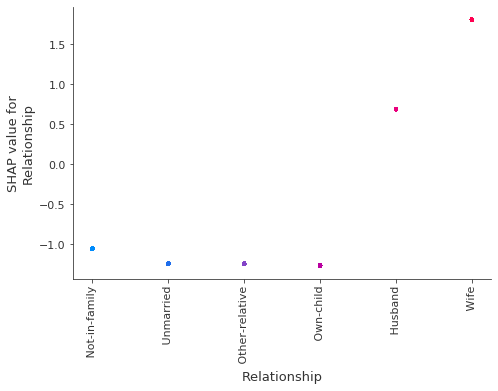

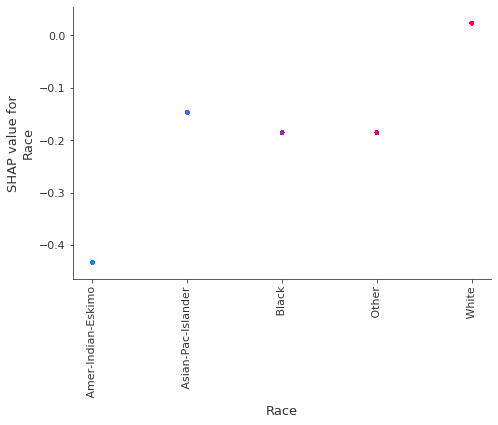

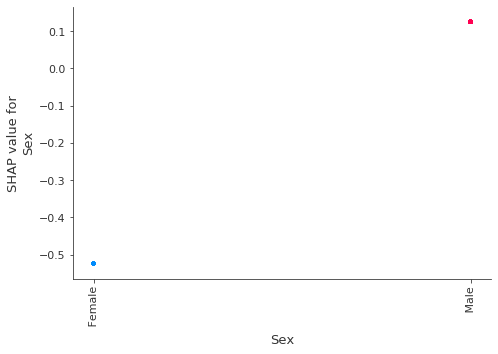

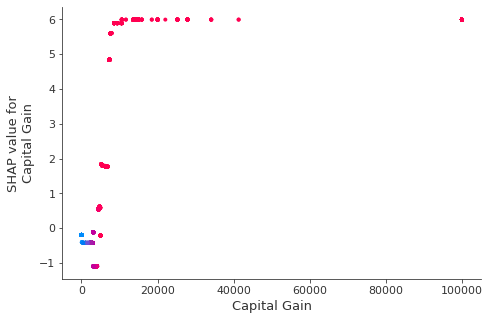

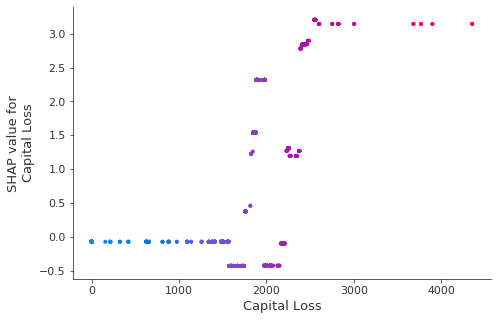

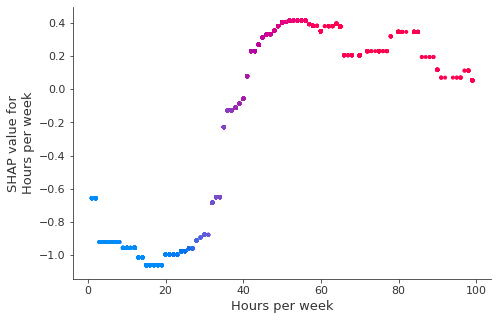

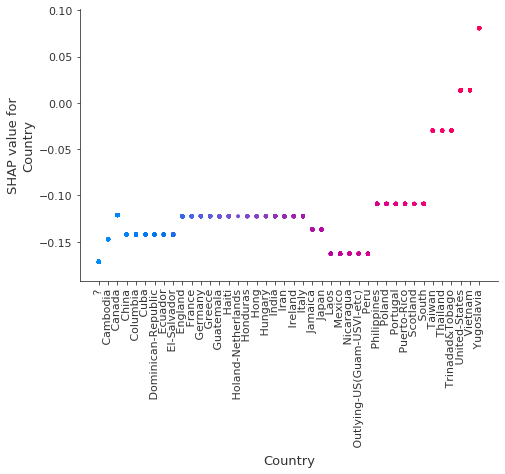

In [43]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

for name in X_train.columns:
    shap.dependence_plot(name, shap_values_ind, X, display_features=X_display)